In [2]:
#GUIDE: https://www.tensorflow.org/tutorials/images/classification

In [1]:
#Import TensorFlow and other libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
#Import dataset
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [4]:
#Check total number of images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


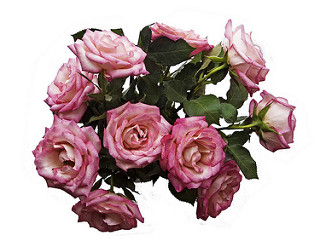

In [7]:
#Look at some roses
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

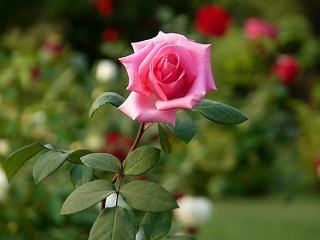

In [8]:
#And some more roses
PIL.Image.open(str(roses[1]))

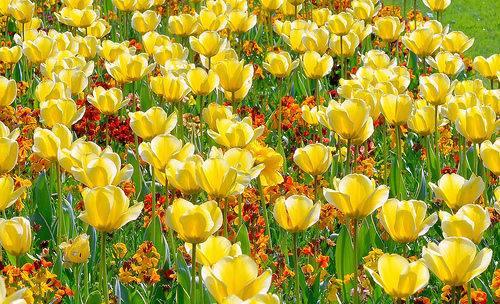

In [9]:
#And some tulips
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

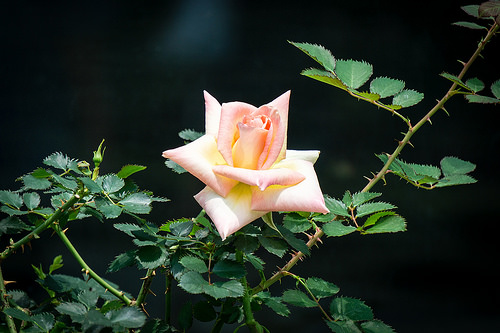

In [10]:
#And some more tulips
PIL.Image.open(str(tulips[1]))

In [13]:
#Turn directory of images into a dataset we can use
#image parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180
#split the photos into a training group (80%) and a validation group (20%)
#Training Group:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [14]:
#Validation Group:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [15]:
#Check the class names
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


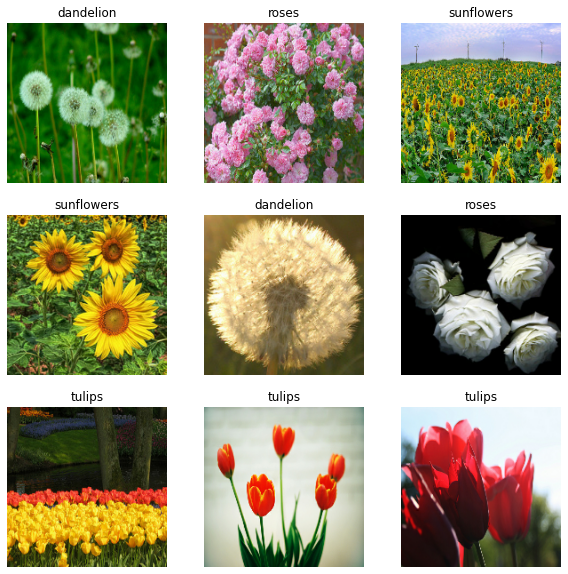

In [18]:
#VISUALIZE THE DATA
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
#*Optional - you can manually iterate over the dataset and retrieve batches of images
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [21]:
#Configure the dataset for performance - make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
#Standardize the data
#reduce the size of the RGB channels by rescaling them by a factor of 100 so they are between 0 and 1
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [27]:
#Apply layer to dataset by including the layer inside your model definition
#Create the model:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#Compile the model:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
#View layers of network using summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 64)       

In [29]:
#Train the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 89s 966ms/step - loss: 1.4726 - accuracy: 0.3566 - val_loss: 1.1450 - val_accuracy: 0.5163
Epoch 2/10
92/92 [==============================] - 87s 945ms/step - loss: 1.0618 - accuracy: 0.5753 - val_loss: 1.0093 - val_accuracy: 0.5967
Epoch 3/10
92/92 [==============================] - 87s 946ms/step - loss: 0.9047 - accuracy: 0.6546 - val_loss: 0.9349 - val_accuracy: 0.6294
Epoch 4/10
92/92 [==============================] - 87s 947ms/step - loss: 0.7067 - accuracy: 0.7388 - val_loss: 0.8590 - val_accuracy: 0.6594
Epoch 5/10
92/92 [==============================] - 87s 946ms/step - loss: 0.4940 - accuracy: 0.8225 - val_loss: 0.9651 - val_accuracy: 0.6444
Epoch 6/10
92/92 [==============================] - 87s 948ms/step - loss: 0.3111 - accuracy: 0.8856 - val_loss: 1.0032 - val_accuracy: 0.6294
Epoch 7/10
92/92 [==============================] - 91s 989ms/step - loss: 0.1687 - accuracy: 0.9438 - val_loss: 1.4483 - val_accuracy: 0.6199

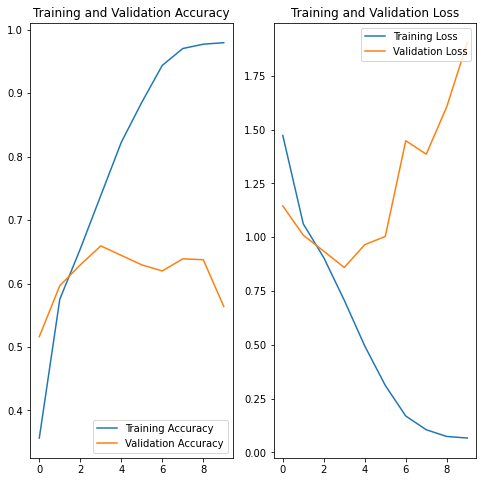

In [30]:
#Visualize results by creating plots of 1)loss and 2)accuracy on the training and validation sets
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


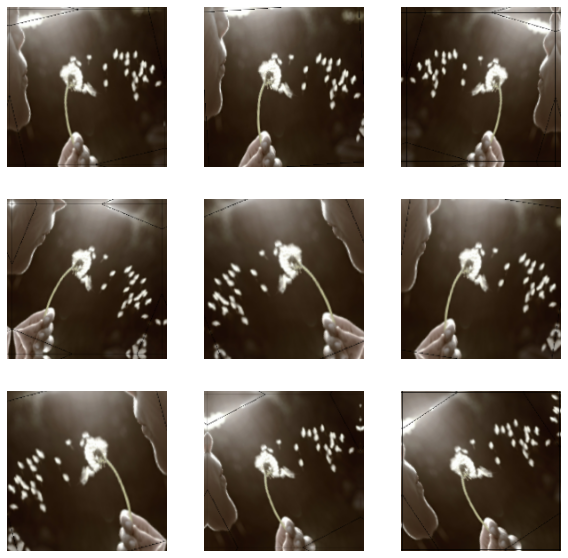

In [31]:
#Data augmentation - generates additional training data from your existing examples by augmenting then using random transformations that yield believable looking images. 
#^helps expose the model to more aspects of the data and generalize better.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)
#see data augmentation in real time
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [32]:
#Dropout - reduce overfitting by applying dropout to a layer
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [34]:
#Compile
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)       

In [35]:
#Train
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 105s 1s/step - loss: 1.2472 - accuracy: 0.4908 - val_loss: 1.1723 - val_accuracy: 0.5436
Epoch 2/15
92/92 [==============================] - 104s 1s/step - loss: 1.0057 - accuracy: 0.6049 - val_loss: 0.9659 - val_accuracy: 0.6185
Epoch 3/15
92/92 [==============================] - 104s 1s/step - loss: 0.8831 - accuracy: 0.6567 - val_loss: 1.0282 - val_accuracy: 0.6226
Epoch 4/15
92/92 [==============================] - 105s 1s/step - loss: 0.8353 - accuracy: 0.6771 - val_loss: 0.7678 - val_accuracy: 0.6962
Epoch 5/15
92/92 [==============================] - 106s 1s/step - loss: 0.7902 - accuracy: 0.6904 - val_loss: 0.7559 - val_accuracy: 0.7016
Epoch 6/15
92/92 [==============================] - 106s 1s/step - loss: 0.7282 - accuracy: 0.7170 - val_loss: 0.7413 - val_accuracy: 0.7003
Epoch 7/15
92/92 [==============================] - 105s 1s/step - loss: 0.7100 - accuracy: 0.7197 - val_loss: 0.7933 - val_accuracy: 0.6907
Epoch 8/15
92

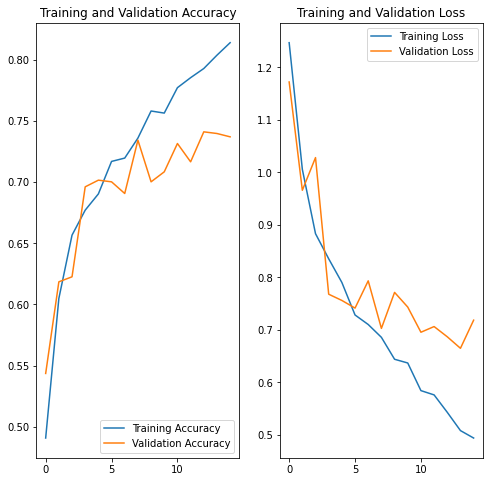

In [36]:
#Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
#Categorize new data
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to sunflowers with a 98.19 percent confidence.
